# Exploring DeepSeek’s Media Narrative: A Text Mining Analysis of News Coverage Trends and Progression

**Lorena Dorado & Parisa Kamizi** 

## Load and Explore the Dataset Structure

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import glob
import json
import html
import re
import string
import logging
import random
from datetime import datetime
from collections import Counter, defaultdict
from langdetect import detect, DetectorFactory
from typing import List, Dict, Any
from tqdm import tqdm

# Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

# Classification & Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download required NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [2]:
# Configure Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('text_mining.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)
logger.info("Setup complete")

2025-02-22 22:59:59,852 - INFO - Setup complete


In [3]:
# Set up text processing configurations
# stop_words = set(stopwords.words('english')) ADD other languages
stop_words = set(stopwords.words('english') + 
                 stopwords.words('spanish') + 
                 stopwords.words('french') + 
                 stopwords.words('german'))

# Add custom stopwords
custom_stopwords = {'ul', 'li', 'ol', 'div', 'span', 'href', 'src', 'img', 'p', 'br', 'nbsp', 'char', 'id', 'av', 'lv'}
stop_words.update(custom_stopwords)

website_stopwords = ['transparency', 'accept', 'partner', 'click', 'consent', 'cookie', 'policy', 'privacy', 'terms', 'use', 'agreement', 'site']
stop_words.update(website_stopwords)

punctuation_set = set(string.punctuation) - {"#"}  # Keep hashtags
lemmatizer = WordNetLemmatizer()

#### Load Data

In [4]:
# Load the data
column_mapping = {
    'source_name': 'source',
    'publishedAt': 'date',
    'content': 'text',
    'title': 'title',
    'description': 'description'
}

csv_files = glob.glob(os.path.join('.', '*.csv'))
dfs = []

for file in csv_files:
    try:
        temp_df = pd.read_csv(file)
        dfs.append(temp_df)
        logger.info(f"Successfully loaded {file}")
    except Exception as e:
        logger.error(f"Error reading file {file}: {str(e)}")

if not dfs:
    raise ValueError("No CSV files were successfully loaded")

news_df = pd.concat(dfs, ignore_index=True)
news_df = news_df[column_mapping.keys()].rename(columns=column_mapping)
news_df['date'] = pd.to_datetime(news_df['date'])

print("\nInitial Dataset Info:")
print(news_df.info())
print("\nFirst few rows:")
print(news_df.head())

2025-02-22 22:59:59,899 - INFO - Successfully loaded .\deepseek_20250214.csv
2025-02-22 22:59:59,899 - INFO - Successfully loaded .\deepseek_20250220.csv
2025-02-22 22:59:59,914 - INFO - Successfully loaded .\deepseek_20250222.csv
2025-02-22 22:59:59,914 - INFO - Successfully loaded .\Deepseek_Day_Five.csv
2025-02-22 22:59:59,914 - INFO - Successfully loaded .\Deepseek_Day_Four.csv
2025-02-22 22:59:59,914 - INFO - Successfully loaded .\Deepseek_Day_One.csv
2025-02-22 22:59:59,932 - INFO - Successfully loaded .\Deepseek_Day_Three.csv
2025-02-22 22:59:59,932 - INFO - Successfully loaded .\Deepseek_Day_Two.csv



Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       856 non-null    object             
 1   date         856 non-null    datetime64[ns, UTC]
 2   text         856 non-null    object             
 3   title        856 non-null    object             
 4   description  828 non-null    object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 40.8+ KB
None

First few rows:
             source                      date  \
0   Android Central 2025-02-10 18:49:23+00:00   
1         MacRumors 2025-02-11 14:54:38+00:00   
2  Business Insider 2025-02-07 14:04:28+00:00   
3  Business Insider 2025-02-10 07:41:09+00:00   
4  Business Insider 2025-02-12 13:06:10+00:00   

                                                text  \
0  What you need to know\r\n<ul><li>Honor is upgr...   

## Data Cleaning with Tokenization and Normalization

In [5]:
#### Text processing pipeline functions
def validate_text(text):
    """Check if text is valid"""
    return "" if not isinstance(text, str) or pd.isna(text) else text

def basic_clean(text):
    """Basic text cleaning"""
    return (html.unescape(text)
            .lower()
            .replace('\n', ' ')
            .replace('\r', ' '))

def remove_special_chars(text):
    """Remove special characters and patterns"""
    return re.sub(r'\[\+\d+ chars\]|https?://\S+|â€™|â€"|[^\w\s\-\'.,!?]', ' ', text)

def remove_num_patterns(text):
    """Remove date patterns and numbers (including those with commas)"""
    return re.sub(r'\b\d{1,4}[-/]\d{1,2}[-/]\d{1,4}\b|\b\d{1,3}(,\d{3})*(\.\d+)?\b|\b\d+\b', '', text)

def clean_whitespace(text):
    """Clean extra whitespace"""
    return re.sub(r'\s+', ' ', text).strip()

def remove_punct(text):
    """Remove punctuation"""
    return "".join(ch for ch in text if ch not in punctuation_set)

def get_tokens(text):
    """Get tokens without stopwords, lemmatize, remove numbers, and filter short tokens"""
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc 
            if token.is_alpha 
            and len(token.text) > 2 
            and not token.is_stop 
            and token.lemma_.lower() not in stop_words 
            and not token.like_num]

def detect_lang(text):
    """Detect language safely"""
    try:
        return 'unknown' if len(text.strip()) < 50 else detect(text)
    except:
        return 'unknown'

def remove_duplicates(df):
    """Remove duplicate articles based on content similarity"""
    df['text_signature'] = df['title'] + df['text'].str[:200]
    original_len = len(df)
    df = df.drop_duplicates(subset=['text_signature'])
    df = df.drop('text_signature', axis=1)
    logger.info(f"Removed {original_len - len(df)} duplicate articles")
    return df

In [6]:
def process_text(text, steps=None):
    if steps is None:
        steps = ['validate', 'basic', 'special', 'num_patterns', 'whitespace', 'punct', 'tokens']
    
    text = validate_text(text)
    
    pipeline_steps = {
        'validate': validate_text,
        'basic': basic_clean,
        'special': remove_special_chars,
        'num_patterns': remove_num_patterns,
        'whitespace': clean_whitespace,
        'punct': remove_punct,
        'tokens': get_tokens
    }
    
    for step in steps:
        text = pipeline_steps[step](text)
    
    return text if isinstance(text, list) else text  # Return tokens as a list if the last step was tokenization

In [7]:
# Remove duplicates
logger.info("Removing duplicates...")
news_df = remove_duplicates(news_df)

# Remove rows with NaN in 'text' column
logger.info("Removing rows with NaN in 'text' column...")
initial_row_count = len(news_df)
news_df = news_df.dropna(subset=['text'])
removed_row_count = initial_row_count - len(news_df)
logger.info(f"Removed {removed_row_count} rows with NaN values in 'text' column.")

# Process text
logger.info("Processing text...")
tqdm.pandas()
news_df['clean_text'] = news_df['text'].progress_apply(
    lambda x: process_text(x, ['validate', 'basic', 'special', 'num_patterns', 'whitespace']))

# Detect languages
logger.info("Detecting languages...")
news_df['language'] = news_df['clean_text'].progress_apply(detect_lang)

# Create cleaned content
logger.info("Creating cleaned content...")
news_df['cleaned_content'] = news_df['text'].progress_apply(
    lambda x: process_text(x, ['validate', 'basic', 'punct', 'whitespace']))

# Generate tokens
logger.info("Generating tokens...")
def get_cleaned_text_and_tokens(text):
    cleaned = process_text(text, ['validate', 'basic', 'punct', 'whitespace'])
    tokens = get_tokens(cleaned)
    return ' '.join(tokens), tokens

temp_results = news_df['text'].progress_apply(get_cleaned_text_and_tokens)
news_df['Cleaned_Text'] = temp_results.apply(lambda x: x[0])
news_df['Tokens'] = temp_results.apply(lambda x: x[1])

# Display processed data sample
print("\nProcessed DataFrame columns:")
print(news_df.columns.tolist())
print("\nSample of processed data:")
print(news_df[['source', 'date', 'clean_text', 'language', 'Tokens']].head())

2025-02-22 23:00:00,008 - INFO - Removing duplicates...
2025-02-22 23:00:00,024 - INFO - Removed 362 duplicate articles
2025-02-22 23:00:00,024 - INFO - Removing rows with NaN in 'text' column...
2025-02-22 23:00:00,024 - INFO - Removed 1 rows with NaN values in 'text' column.
2025-02-22 23:00:00,024 - INFO - Processing text...
100%|█████████████████████████████████████████████████████████████████████████████| 678/678 [00:00<00:00, 29268.91it/s]
2025-02-22 23:00:00,055 - INFO - Detecting languages...
100%|███████████████████████████████████████████████████████████████████████████████| 678/678 [00:04<00:00, 143.70it/s]
2025-02-22 23:00:04,774 - INFO - Creating cleaned content...
100%|█████████████████████████████████████████████████████████████████████████████| 678/678 [00:00<00:00, 21707.92it/s]
2025-02-22 23:00:04,805 - INFO - Generating tokens...
100%|███████████████████████████████████████████████████████████████████████████████| 678/678 [00:05<00:00, 114.79it/s]


Processed DataFrame columns:
['source', 'date', 'text', 'title', 'description', 'clean_text', 'language', 'cleaned_content', 'Cleaned_Text', 'Tokens']

Sample of processed data:
             source                      date  \
0   Android Central 2025-02-10 18:49:23+00:00   
1         MacRumors 2025-02-11 14:54:38+00:00   
2  Business Insider 2025-02-07 14:04:28+00:00   
3  Business Insider 2025-02-10 07:41:09+00:00   
4  Business Insider 2025-02-12 13:06:10+00:00   

                                          clean_text language  \
0  what you need to know ul li honor is upgrading...       en   
1  apple in recent months passed over the chinese...       en   
2  aiden gomez is one of the google brain researc...       en   
3  demis hassabis, cofounder and ceo of google de...       en   
4  byd has become the latest automaker to incorpo...       en   

                                              Tokens  
0  [need, know, ullihonor, upgrade, yoyo, assista...  
1  [apple, recent, month,

## Descriptive Statistics

In [8]:
def descriptive_stats_all(df: pd.DataFrame, tokens_col: str = 'Tokens', 
                         text_col: str = 'text', title: str = "Dataset",
                         num_tokens: int = 5, plot: bool = True) -> Dict[str, Any]:

    # Initialize results dictionary
    stats = {}
    
    # Get all tokens
    all_tokens = [token for tokens in df[tokens_col] for token in tokens]
    token_counts = Counter(all_tokens)
    
    # Basic token statistics
    stats['total_tokens'] = len(all_tokens)
    stats['unique_tokens'] = len(set(all_tokens))
    stats['total_characters'] = len(''.join(all_tokens))
    stats['lexical_diversity'] = stats['unique_tokens'] / stats['total_tokens'] if stats['total_tokens'] > 0 else 0
    
    # Document statistics
    stats['total_documents'] = len(df)
    
    # Token length statistics
    token_lengths = [len(token) for token in all_tokens]

    # Top tokens
    stats['top_tokens'] = token_counts.most_common(num_tokens)
    
    # Print results if verbose
    print(f"\nDescriptive Statistics for '{title}':")
    print("-" * 50)
    print(f"Total documents: {stats['total_documents']:,}")
    
    print(f"\nToken-level Statistics:")
    print(f"Total tokens: {stats['total_tokens']:,}")
    print(f"Unique tokens: {stats['unique_tokens']:,}")
    print(f"Total characters: {stats['total_characters']:,}")
    print(f"Lexical diversity: {stats['lexical_diversity']:.3f}")
    
    print(f"\nTop {num_tokens} most frequent tokens:")
    for token, count in stats['top_tokens']:
        print(f"{token}: {count:,}")
    
    return stats

stats = descriptive_stats_all(news_df, tokens_col='Tokens', text_col='text',
                              title="News Articles", num_tokens=10, plot=True)


Descriptive Statistics for 'News Articles':
--------------------------------------------------
Total documents: 678

Token-level Statistics:
Total tokens: 10,904
Unique tokens: 4,327
Total characters: 72,706
Lexical diversity: 0.397

Top 10 most frequent tokens:
deepseek: 502
openai: 149
model: 121
chinese: 110
artificial: 81
chatgpt: 76
nvidia: 67
tech: 66
new: 64
app: 62


## Topic Modeling

In [9]:
# Check for NaN values
print(f"Number of NaN values in 'clean_text': {news_df['clean_text'].isna().sum()}")

# Remove rows with NaN values
news_df = news_df.dropna(subset=['clean_text'])
print(f"Shape of DataFrame after removing NaN values: {news_df.shape}")

Number of NaN values in 'clean_text': 0
Shape of DataFrame after removing NaN values: (678, 10)


In [10]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words), max_features=5000, max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(news_df['clean_text'])

# Create Count vectorizer
count_vectorizer = CountVectorizer(stop_words=list(stop_words), max_features=5000, max_df=0.95, min_df=2)
count_matrix = count_vectorizer.fit_transform(news_df['clean_text'])

In [11]:
# Function to display topics
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## NMF

In [12]:
# Fit NMF model
n_topics = 5
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_output = nmf_model.fit_transform(tfidf_matrix)

# Display the topics
feature_names = tfidf_vectorizer.get_feature_names_out()
print("NMF Topics:")
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())

NMF Topics:

Topic 00
  iab (9.55)
  words (9.55)
  partners (9.55)
  device (9.29)
  framework (9.26)

Topic 01
  deepseek (20.24)
  r1 (6.16)
  chatgpt (2.73)
  nvidia (1.99)
  bloomberg (1.12)

Topic 02
  chinese (1.80)
  model (1.37)
  intelligence (1.14)
  tech (1.09)
  app (1.08)

Topic 03
  openai (9.51)
  chatgpt (3.40)
  o3 (3.16)
  altman (3.15)
  mini (3.11)

Topic 04
  weekly (5.24)
  coverage (4.91)
  learn (4.91)
  updates (4.91)
  newsletters (4.89)


## LSA

In [13]:
# Fit LSA model
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_output = lsa_model.fit_transform(tfidf_matrix)

print("\nLSA Topics:")
display_topics(lsa_model, tfidf_vectorizer.get_feature_names_out())


LSA Topics:

Topic 00
  iab (5.07)
  partners (5.07)
  words (5.07)
  device (4.94)
  part (4.92)

Topic 01
  deepseek (7.31)
  r1 (2.44)
  openai (2.14)
  chatgpt (1.72)
  model (1.01)

Topic 02
  deepseek (2.25)
  r1 (0.86)
  chatgpt (0.60)
  flyer (0.25)
  gpu (0.21)

Topic 03
  openai (38.20)
  o3 (14.33)
  mini (14.09)
  altman (13.45)
  chatgpt (13.25)

Topic 04
  weekly (18.56)
  learn (17.60)
  updates (17.60)
  coverage (17.60)
  newsletters (17.53)


## LDA

In [14]:
# Fit LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_output = lda_model.fit_transform(count_matrix)

print("\nLDA Topics:")
display_topics(lda_model, count_vectorizer.get_feature_names_out())


LDA Topics:

Topic 00
  deepseek (3.40)
  chinese (2.53)
  new (1.44)
  model (1.41)
  intelligence (1.26)

Topic 01
  artificial (1.98)
  deepseek (1.81)
  daily (1.63)
  latest (1.43)
  intelligence (1.29)

Topic 02
  deepseek (10.49)
  nvidia (3.08)
  r1 (2.34)
  openai (1.13)
  ia (1.09)

Topic 03
  deepseek (5.99)
  model (1.70)
  including (1.40)
  r1 (1.39)
  store (1.31)

Topic 04
  openai (6.77)
  deepseek (4.28)
  chatgpt (2.99)
  mini (1.99)
  o3 (1.93)


In [15]:
# Visualize LDA results
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, count_matrix, count_vectorizer)
pyLDAvis.display(lda_vis)

The LDA visualization show five distinct topics, with Topic 1 being the most prevalent and Topics 2 and 5 showing some overlap. The most salient terms include AI-related words like "openai," "nvidia," and "deepseek," alongside technical and business-related terms, indicating a focus on AI companies, technologies, and partnerships. Term frequency analysis highlights "deepseek" as the most frequent term. The marginal topic distribution shows the relative importance of different topics within the corpus.

## Model Evaluation

The higher coherence score will be selected as the best model as it indicates more interpretable topics.

In [16]:
# Calculate coherence scores for each model
def calculate_coherence(model, feature_names, doc_term_matrix):
    coherence_scores = []
    for topic in model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        word_indices = [list(feature_names).index(word) for word in top_words]
        topic_vectors = doc_term_matrix[:, word_indices]
        pairwise_similarities = cosine_similarity(topic_vectors.T)
        coherence = pairwise_similarities.mean()
        coherence_scores.append(coherence)
    return coherence_scores

nmf_coherence = calculate_coherence(nmf_model, tfidf_vectorizer.get_feature_names_out(), tfidf_matrix)
lsa_coherence = calculate_coherence(lsa_model, tfidf_vectorizer.get_feature_names_out(), tfidf_matrix)
lda_coherence = calculate_coherence(lda_model, count_vectorizer.get_feature_names_out(), count_matrix)

print("\nCoherence Scores:")
print(f"NMF: {np.mean(nmf_coherence):.4f}")
print(f"LSA: {np.mean(lsa_coherence):.4f}")
print(f"LDA: {np.mean(lda_coherence):.4f}")


Coherence Scores:
NMF: 0.4934
LSA: 0.4854
LDA: 0.2895


Use the most frequent words to try to discern what semantic groups the unsupervised topics might have identified

In [17]:
# Extract top words and their frequencies for each topic
n_top_words = 15
topic_word_freq = []

for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = tfidf_vectorizer.get_feature_names_out()[top_features_ind]
    weights = topic[top_features_ind]
    topic_word_freq.append(dict(zip(top_features, weights)))

# Calculate the relevance of each word across all topics
word_topic_relevance = {}
for topic_idx, word_freq in enumerate(topic_word_freq):
    for word, freq in word_freq.items():
        if word not in word_topic_relevance:
            word_topic_relevance[word] = []
        word_topic_relevance[word].append((topic_idx, freq))
        
# Identify semantic groups based on word relevance across topics
threshold = 0.05
semantic_groups = {}
for word, relevances in word_topic_relevance.items():
    relevant_topics = [topic for topic, score in relevances if score >= threshold]
    if len(relevant_topics) > 1:
        group_name = f"Group_{'-'.join(map(str, relevant_topics))}"
        if group_name not in semantic_groups:
            semantic_groups[group_name] = []
        semantic_groups[group_name].append(word)

# Display the identified semantic groups with interpretations
topic_interpretations = [
    "Topic 1",
    "Topic 2",
    "Topic 3",
    "Topic 4",
    "Topic 5"
]

print("\nIdentified semantic groups:")
for group, words in semantic_groups.items():
    topics = [int(t) for t in group.split('_')[1].split('-')]
    interpretations = [topic_interpretations[t] for t in topics]
    print(f"\n{group}: {', '.join(interpretations)}")
    print(f"Words: {', '.join(words)}")


Identified semantic groups:

Group_1-3: Topic 2, Topic 4
Words: r1, chatgpt, o1, ia

Group_2-3: Topic 3, Topic 4
Words: artificial


## Classification Models

In [18]:
# Data Preparation
def create_class_labels(nmf_features):
    dominant_topics = np.argmax(nmf_features, axis=1)
    
    def map_to_semantic_class(topic):
        if topic in [1, 3]:  # AI Models/Companies specific topics
            return "AI Models and Technologies"
        elif topic == 2:  # General AI development
            return "General Artificial Intelligence"
        else:  # Industry framework and news (topics 0 and 4)
            return "Other AI Topics"
    
    return np.array([map_to_semantic_class(topic) for topic in dominant_topics])

In [19]:
# Create labels and encode them
label_encoder = LabelEncoder()
labels = create_class_labels(nmf_output)
encoded_labels = label_encoder.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    nmf_output,
    encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (542, 5)
Test set shape: (136, 5)


We perform cross-validation to ensures model stability by testing performance across multiple data splits, helping to detect inconsistencies. It also helps identify overfitting by checking if performance varies across different folds. It also maximizes training data usage, providing a reliable way to compare models based on both mean accuracy and variance.

In [20]:
# Model Evaluation Function
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test, label_encoder):
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Train final model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print results
    print(f"\n{model_name} Results:")
    print("Cross-validation scores:")
    print(f"Mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xticks(rotation=0)
    plt.show()
    
    return {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

Random Forest Model


Random Forest Results:
Cross-validation scores:
Mean accuracy: 0.9354 (+/- 0.0260)

Classification Report:
                                 precision    recall  f1-score   support

     AI Models and Technologies       0.94      0.91      0.93        55
General Artificial Intelligence       0.94      0.97      0.96        66
                Other AI Topics       0.87      0.87      0.87        15

                       accuracy                           0.93       136
                      macro avg       0.92      0.92      0.92       136
                   weighted avg       0.93      0.93      0.93       136



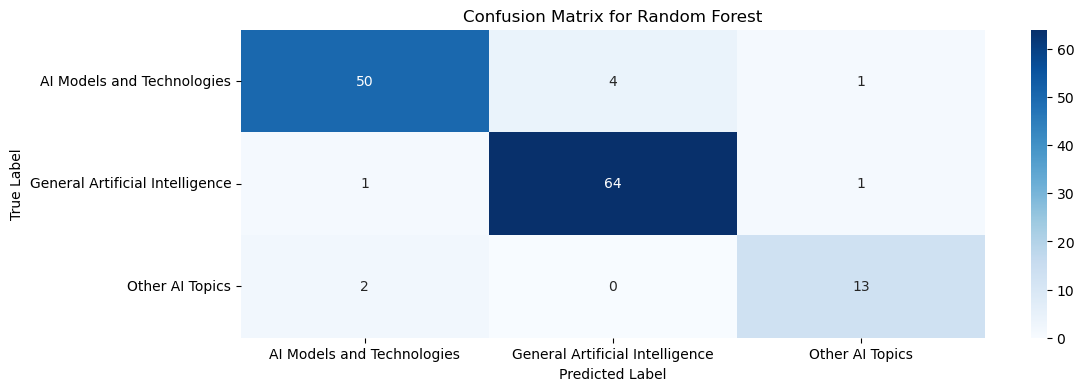

In [21]:
# RF
rf_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_results = evaluate_model(
    rf_pipeline, 
    "Random Forest", 
    X_train, X_test, 
    y_train, y_test,
    label_encoder
)

The Random Forest model achieved a mean accuracy of 93.54% (±2.60%) in cross-validation, suggesting a stable performance. The classification report shows strong precision, recall, and F1-scores across all categories, with the confusion matrix indicating minimal misclassifications.

Logistic Regression Model


Logistic Regression Results:
Cross-validation scores:
Mean accuracy: 0.9188 (+/- 0.0459)

Classification Report:
                                 precision    recall  f1-score   support

     AI Models and Technologies       0.96      0.87      0.91        55
General Artificial Intelligence       0.97      0.91      0.94        66
                Other AI Topics       0.58      0.93      0.72        15

                       accuracy                           0.90       136
                      macro avg       0.84      0.91      0.86       136
                   weighted avg       0.92      0.90      0.90       136



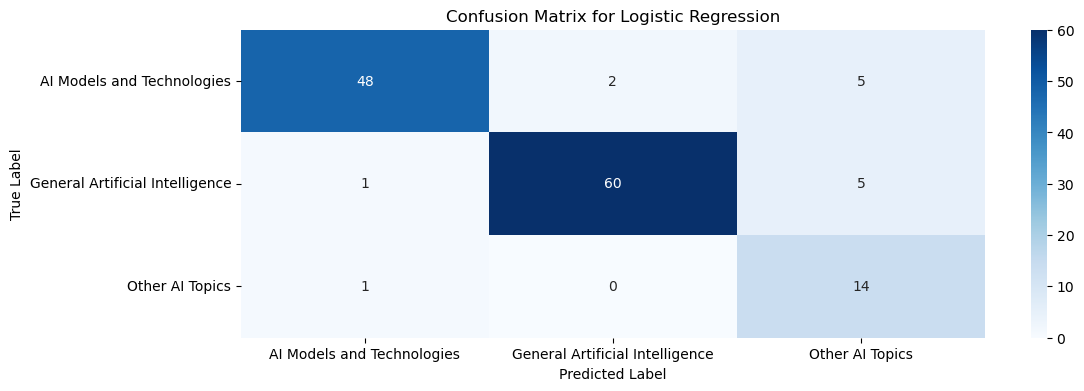

In [22]:
# Logreg
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        random_state=42,
        class_weight='balanced'
    ))
])

lr_results = evaluate_model(
    lr_pipeline, 
    "Logistic Regression", 
    X_train, X_test, 
    y_train, y_test,
    label_encoder
)

Support Vector Machine Model


SVM Results:
Cross-validation scores:
Mean accuracy: 0.9059 (+/- 0.0458)

Classification Report:
                                 precision    recall  f1-score   support

     AI Models and Technologies       0.98      0.82      0.89        55
General Artificial Intelligence       0.97      0.91      0.94        66
                Other AI Topics       0.54      1.00      0.70        15

                       accuracy                           0.88       136
                      macro avg       0.83      0.91      0.84       136
                   weighted avg       0.92      0.88      0.89       136



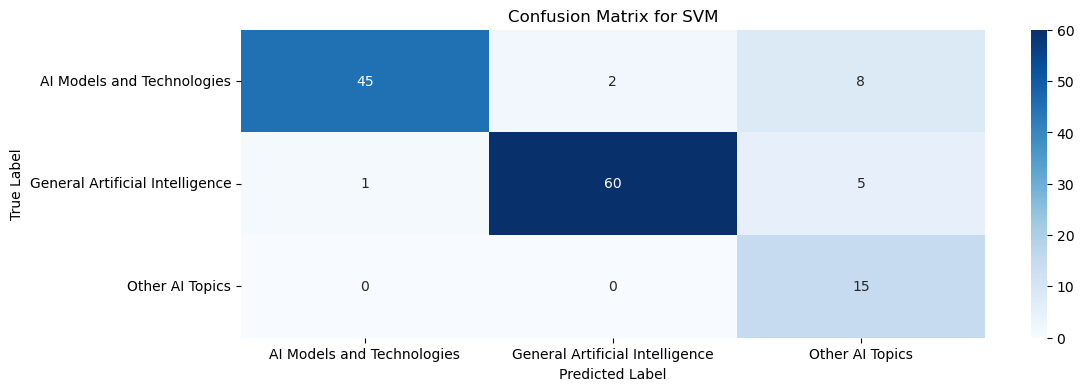

In [23]:
# SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(
        kernel='rbf',
        probability=True,
        random_state=42,
        class_weight='balanced'
    ))
])

svm_results = evaluate_model(
    svm_pipeline, 
    "SVM", 
    X_train, X_test, 
    y_train, y_test,
    label_encoder
)

XGBoost Model


XGBoost Results:
Cross-validation scores:
Mean accuracy: 0.9336 (+/- 0.0378)

Classification Report:
                                 precision    recall  f1-score   support

     AI Models and Technologies       0.94      0.89      0.92        55
General Artificial Intelligence       0.93      0.95      0.94        66
                Other AI Topics       0.88      0.93      0.90        15

                       accuracy                           0.93       136
                      macro avg       0.91      0.93      0.92       136
                   weighted avg       0.93      0.93      0.93       136



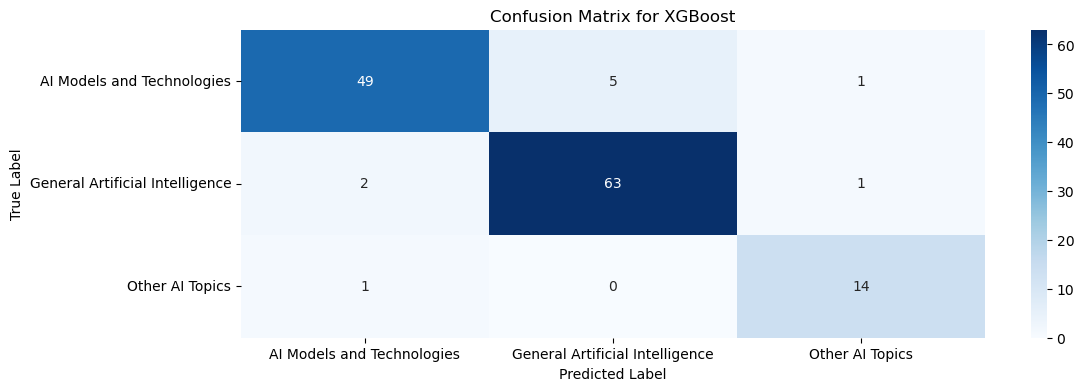

In [24]:
# XGB
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softprob'
    ))
])

xgb_results = evaluate_model(
    xgb_pipeline, 
    "XGBoost", 
    X_train, X_test, 
    y_train, y_test,
    label_encoder
)

## Model Comparison

In [25]:
models_comparison = [
    rf_results,
    lr_results,
    svm_results,
    xgb_results
]

# model names
model_names = ["Random Forest", "Logistic Regression", "SVM", "XGBoost"]

# results into a DataFrame
df_models_comparison = pd.DataFrame({
    "Model": model_names,
    "CV Mean Score": [results["cv_mean"] for results in models_comparison],
    "CV Std (±2)": [results["cv_std"] * 2 for results in models_comparison]
})

df_models_comparison = df_models_comparison.sort_values(by="CV Mean Score", ascending=False)

# Display the DataFrame
df_models_comparison

,Model,CV Mean Score,CV Std (±2)
0,Random Forest,0.935440,0.026004
3,XGBoost,0.933571,0.037788
1,Logistic Regression,0.918824,0.045891
2,SVM,0.905912,0.045822


**References**

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python: Machine learning-based solutions for common real-world (NLP) applications [GitHub repository]. O’Reilly. https://github.com/blueprints-for-text-analytics-python/blueprints-text/tree/master

OpenAI. (2025). ChatGPT (Feb 13 version) [Large language model]. https://openai.com